In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pprint
import sys
from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.gridworld import GridworldEnv
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

## Dynamic Programming

### Policy Iteration
2 steps <br>
    1 Iterative Policy Evaluation <br>
    2 Policy Improvement <br>

In [294]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = 0
            for a, action_prob in enumerate(policy[s]):
                for  prob, next_state, reward, done in env.P[s][a]:
                    v += action_prob * (reward + discount_factor * prob * V[next_state])
            delta = max(delta, np.abs(v - V[s]))
            
            # **** update value function ****
            V[s] = v
        if delta < theta:
            break
        break
    return np.array(V)

In [297]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)
print("\nReshaped Grid (rounded) Value Function:")
print(np.around(v.reshape(env.shape)))


Reshaped Grid (rounded) Value Function:
[[ 0. -1. -1. -1.]
 [-1. -2. -2. -2.]
 [-1. -2. -2. -2.]
 [-1. -2. -2.  0.]]


In [262]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    def one_step_lookahead(state, V):
        Q = np.zeros(env.nA)
        for a in range(env.nA):
            # we know probability of transition a->s' so this one is model base
            for prob, next_state, reward, done in env.P[state][a]:
                Q[a] += reward + discount_factor * prob * V[next_state]
        return Q
    
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_eval_fn(policy, env, discount_factor)
        policy_stable = True
        for s in range(env.nS):
            chosen_a = np.argmax(policy[s])
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            if chosen_a != best_a:
                policy_stable = False
            
            # **** update policy from one step look ahead ****
            policy[s] = np.eye(env.nA)[best_a]
        if policy_stable:
            break
    return policy, V

In [263]:
policy, v = policy_improvement(env)
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")
print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



### Value Iteration

In [304]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    def one_step_lookahead(state, V):
        Q = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                Q[a] += reward + discount_factor * prob* V[next_state]
        return Q
    
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            Q = one_step_lookahead(s, V)
            best_action_value = np.max(Q)
            delta = max(delta, np.abs(best_action_value - V[s]))
            
            # **** update Value from best action of one step look ahead ****
            V[s] = best_action_value        
        if delta < theta:
            break
    
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        policy[s, best_action] = 1.0
    
    return policy, V

In [305]:
policy, v = value_iteration(env)
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")
print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



# Monte Carlo

In [85]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episode = []
        state = env.reset()
        while True:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        # update V
        for i, episode_step in enumerate(episode):
            state = episode_step[0]
            G = sum([x[2]*(discount_factor**idx_step) for idx_step, x in enumerate(episode[i:])])
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
        
    return V

In [112]:
v = mc_prediction(lambda _: np.random.choice([0,1,2,3]), env, num_episodes=1000)
print("Reshaped Grid Value Function:")
v_array = [x[1] for x in sorted(v.items())]
np.array(v_array).reshape(env.shape)

Episode 1000/1000.Reshaped Grid Value Function:


array([[  0.        , -14.07936508, -19.6119403 , -20.89285714],
       [-15.43340858, -18.49411765, -19.33177205, -18.84974471],
       [-20.98149576, -20.04227642, -16.78145695, -12.35791544],
       [-22.64917326, -20.45090016, -13.93675027,   0.        ]])

## Monte Carlo with Epsilon-Greedy Policies

In [2]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
#         best_action = np.argmax(Q[observation])
        best_action = np.random.choice(np.flatnonzero(Q[observation] == Q[observation].max()))
        A[best_action] += (1.0 - epsilon)
        return np.random.choice(np.arange(len(A)), p=A)
    return policy_fn

In [3]:
def convert_Q_to_V(Q):
    V = np.array([0]*env.nS)
    for state, action_value in Q.items():
        V[state] = np.max(action_value)
    return V.reshape(env.shape)

In [165]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = []
        state = env.reset()
        while True:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # update Q
        for i, episode_step in enumerate(episode):
            state, action, _ = episode_step
            sa_pair = (state, action)
            G = sum([x[2]*(discount_factor**idx_step) for idx_step, x in enumerate(episode[i:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    return Q


In [803]:
Q = mc_control_epsilon_greedy(env, num_episodes=20, epsilon=0.1)

In [804]:
convert_Q_to_V(Q)

array([[  0,  -1, -13, -15],
       [ -1, -15, -11,  -4],
       [ -5, -18, -20,  -1],
       [-36, -38,  -1,   0]])

## TD SARSA with Epsilon-Greedy Policies
n-step = 1

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        action = policy(state)

        for t in range(10000000):
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state)
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action] #'TD error'
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    return Q

In [5]:
Q = sarsa(env, 200)
convert_Q_to_V(Q)

Episode 200/200.

array([[ 0,  0, -1, -2],
       [ 0, -1, -2, -2],
       [-1, -2, -2,  0],
       [-2, -1,  0,  0]])

## TD Q-Learning with Epsilon-Greedy Policies

In [2]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        for t in range(10000000):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)

            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    return Q

In [15]:
Q = q_learning(env, 200)
convert_Q_to_V(Q)

Episode 200/200.

array([[ 0,  0, -1, -2],
       [ 0, -1, -2, -1],
       [-1, -2, -1,  0],
       [-2, -1,  0,  0]])

In [246]:
env = GridworldEnv()
state = env.reset()
env.render()

T  o  o  o
o  o  o  o
o  o  o  o
x  o  o  T


### Sarsa n-step [my own code] this code is wrong see p.147

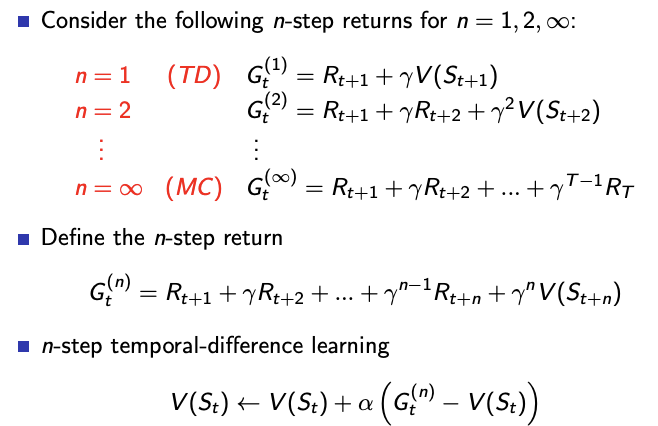

In [13]:
def sarsa_n_steps(env, num_episodes, n_steps, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        action = policy(state)

        done = False
        while True:
            steps = []
            for n in range(n_steps):
                next_state, reward, done, _ = env.step(action)
                next_action = policy(next_state)
                steps.append((state, action, reward))

                if done:
                    break

                action = next_action
                state = next_state
            
            for i, step in enumerate(steps):
                td_target = sum([(discount_factor**idx_step)*x[2] for idx_step, x in enumerate(steps[i:i+n_steps])])
                td_target += Q[next_state][next_action] # add the last action-value
                
                current_state, current_action, _ = steps[i]
                td_error = td_target - Q[current_state][current_action]
                Q[current_state][current_action] += alpha * td_error
            
            if done:
                break
    return Q

In [14]:
Q = sarsa_n_steps(env, 200, 4)
convert_Q_to_V(Q)

Episode 200/200.

array([[ 0,  0, -2, -3],
       [ 0, -2, -2, -2],
       [-2, -2, -2,  0],
       [-3, -2, -1,  0]])

### Sasa TD(λ) [my own code]

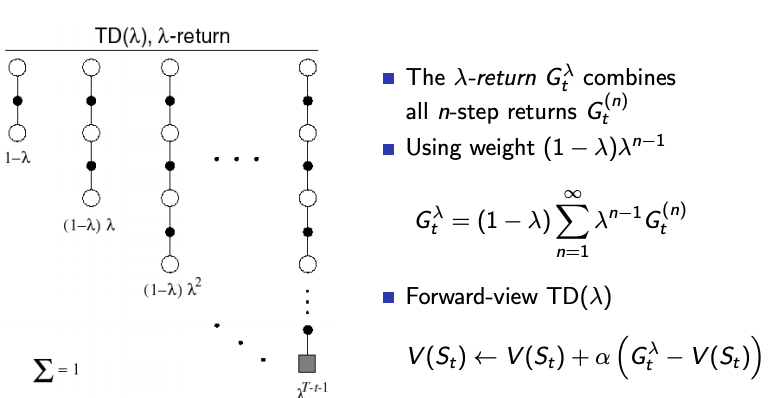

In [9]:
def sarsa_lamba(env, num_episodes, lamb, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()
        action = policy(state)

        done = False
        steps = []
        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state)
            steps.append((state, action, reward))
            if done:
                break

            action = next_action
            state = next_state
        
        for i, step in enumerate(steps):
            G = sum([(discount_factor**idx_step)*x[2] for idx_step, x in enumerate(steps[i:])])
            current_state, current_action, _ = steps[i]
            td_error = G - Q[current_state][current_action]
            Q[current_state][current_action] += alpha * td_error
        
    return Q

In [12]:
Q = sarsa_lamba(env, 200, 0.9)
convert_Q_to_V(Q)

Episode 200/200.

array([[ 0,  0, -2, -3],
       [-1, -5, -3, -4],
       [-2, -3, -2,  0],
       [-3, -2, -1,  0]])

### Eligibility traces (from David's slide p.29)

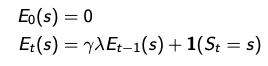

In [7]:
def sarsa_eligibility_traces(env, num_episodes, lamb, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = np.zeros((env.nS, env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        E = np.zeros((env.nS, env.action_space.n))
        state = env.reset()
        action = policy(state)

        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state)
            
            td_error = (reward+discount_factor*Q[next_state][next_action])\
                        - Q[state][action]
            E[state][action] = E[state][action] + 1
            
            Q = Q + alpha*td_error*E
            E *= discount_factor*lamb
                
            if done:
                break

            action = next_action
            state = next_state
    return Q


In [8]:
def convert_Q_numpy_to_V(Q):
    V = np.array([0]*env.nS)
    for state in range(len(Q)):
        V[state] = np.max(Q[state])
    return V.reshape(env.shape)

In [840]:
Q = sarsa_eligibility_traces(env, 2, 0.1)
convert_Q_numpy_to_V(Q)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])